In [ ]:
from ipywidgets import interact
from fastai.basics import *

In [ ]:
plt.rc('figure', dpi=90) # dpi= dots per inch

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

In [ ]:
def f(x): return 3*x**2 + 2*x + 1

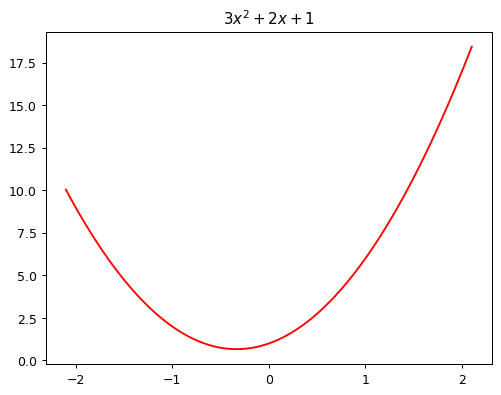

In [ ]:
plot_function(f, "$3x^2 + 2x + 1$")

In [ ]:
def quad(a, b, c, x): return a*x**2 + b*x + c

In [ ]:
from functools import partial
def mk_quad(a,b,c): return partial(quad, a,b,c)

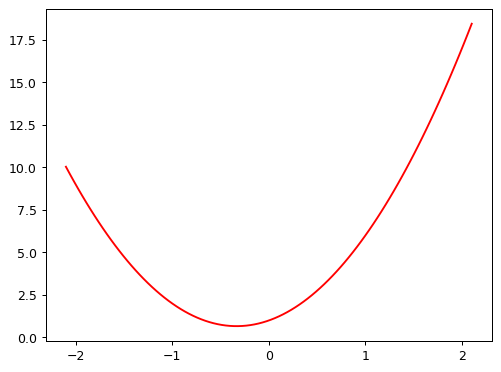

In [ ]:
f2 = mk_quad(3,2,1)
plot_function(f2)

In [ ]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [ ]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

/tmp/ipython-input-1958766108.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)


In [ ]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

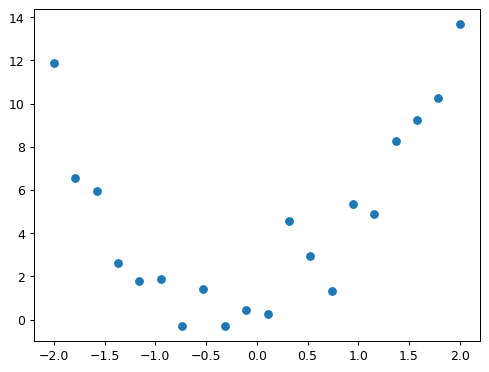

In [ ]:
plt.scatter(x,y);

In [ ]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [ ]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

In [ ]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [ ]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [ ]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

In [ ]:
abc = torch.tensor([1.1,1.1,1.1])

In [ ]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

In [ ]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()

In [ ]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

In [ ]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)

print(f'loss={loss:.2f}')

loss=2.40


| Step | Code                     | Explanation                                                                          |
| ---- | ------------------------ | ------------------------------------------------------------------------------------ |
| 1    | `loss = quad_mae(abc)`   | Compute the current loss using the variable `abc`.                                   |
| 2    | `loss.backward()`        | Calculate the gradient of the loss w.r.t. `abc`. The result is stored in `abc.grad`. |
| 3    | `with torch.no_grad():`  | Temporarily stop PyTorch from tracking operations.                                   |
| 4    | `abc -= abc.grad * 0.01` | Update `abc` manually using gradient descent (learning rate = 0.01).                 |
| 5    | `print(...)`             | Show the current step and loss value.                                                |


In [ ]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


**On adding torch.nograd:**

* loss(abc) -> new loss value of new abc

* loss.backward() -> d(loss)/d(abc)

  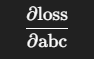

* abc -= abc.grad*0.01 -> updating abc value

**If I dont put torch.no_grad:**

* loss(abc) -> new loss value of new abc

* loss.backward() -> d(loss)/d(old_abc) = d(loss)/d(abc) * d(abc)/d(old_abc)

  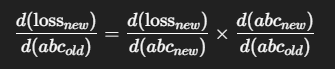

* abc -= abc.grad*0.01 -> updating abc value



---


**Approximation in Neural Network - Relu**

The way a neural network approximates a function actually turns out to be very simple. The key trick is to combine two extremely basic steps:

* Matrix multiplication, which is just multiplying things together and then adding them up
* The function max(x, 0), which simply replaces all negative numbers with zero.

In PyTorch, the function
 is written as np.clip(x,0). The combination of a linear function and this max() is called a rectified linear function, and it can be implemented like this:

In [ ]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

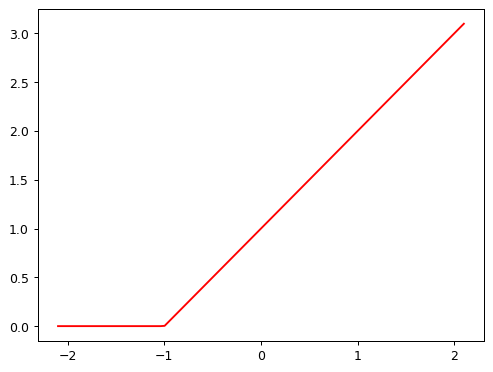

In [ ]:
plot_function(partial(rectified_linear, 1,1))

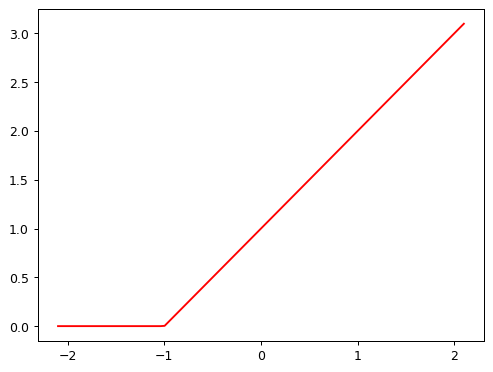

In [ ]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

In [ ]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [ ]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…